<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/AR%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARMAモデル

自己回帰移動平均モデルと呼ばれ、MAモデルとARモデルを組み合わせたモデルである。

次数：p
次数：q



### MAモデル　p

移動平均モデル。「将来のYは過去の誤差によって説明される」
　「将来の予測値は、過去の予測値と実績値との誤差により決まる」

例えば、今月の売上量が、本来売上げる量より多かったら、来月は売上量が増える

次数：<font color="red">q</font>

過去どれだけ遡ると良くなるのかを試行する。

### ARモデル　q


自己回帰　「将来のYは、過去のYによって説明される」

「将来の予測値は、過去の予測値により決まる」、

例えば、今月の売上量が多かったら、来月は売上量が増える

次数：p

# ARモデルの実装
シンプル。そして思いのほか高性能



### データの読み込み]


1.   読込
2.   カラムそぎ落とし
2.   groupby



今回使用するデータは、気温の時系列データです。

データ配布元：http://www.data.jma.go.jp/gmd/risk/obsdl/index.php

**まずは、理解を容易にするため、気温データのみを用います**

In [ ]:
#データの読込
import pandas as pd
weather_df = pd.read_csv("/content/weather (1).csv", encoding="shift-jis")

In [ ]:
#そして確認
weather_df

,年月日,平均気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),平均現地気圧(hPa)
0,2015/1/1,3.7,0.0,4.4,1.3,1000.4
1,2015/1/2,2.7,0.0,2.1,6.0,1007.4
2,2015/1/3,3.8,0.0,3.0,8.9,1012.0
3,2015/1/4,4.0,0.0,1.3,6.0,1010.4
4,2015/1/5,6.9,0.0,2.4,8.9,1014.6
...,...,...,...,...,...,...
1822,2019/12/28,6.8,0.0,3.5,8.8,1019.9
1823,2019/12/29,7.0,0.0,1.9,8.3,1026.5
1824,2019/12/30,6.7,0.5,1.8,0.0,1021.0
1825,2019/12/31,8.2,0.0,3.6,8.6,1009.1


#### データ整形

In [ ]:
# 今回使わないカラムを削除する。他の方法もありますが、今回はこんな感じで。
weather_df = weather_df.drop(columns = ["降水量の合計(mm)","平均現地気圧(hPa)","平均風速(m/s)","日照時間(時間)"])
weather_df

,年月日,平均気温(℃)
0,2015/1/1,3.7
1,2015/1/2,2.7
2,2015/1/3,3.8
3,2015/1/4,4.0
4,2015/1/5,6.9
...,...,...
1822,2019/12/28,6.8
1823,2019/12/29,7.0
1824,2019/12/30,6.7
1825,2019/12/31,8.2


In [ ]:
#infoも確認。
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   年月日      1827 non-null   object 
 1   平均気温(℃)  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


infoにて確認した所、<font color="red">日付が文字列型</font>になっているんですかね。　それじゃ困る。

時系列解析の定石：時系列をdatetimeにしてindexに格納格納 ⇒ それを行いましょう。

In [ ]:
# weather_df["年月日"]をdatetimeに変換した後、indexにぶち込みます。
# そしたらカラムの["年月日"]はいらないのでドロップしましょう。
weather_df.index = pd.to_datetime(weather_df["年月日"], infer_datetime_format=True) 
weather_df = weather_df.drop(columns = ["年月日"])
weather_df

KeyError: ignored

In [ ]:
# すべての範囲を月ごとの平均にしています。1月の平均気温に。⇒データ数の圧縮。いちいち一日毎の予測なんてしていられないでしょう。
data = weather_df.resample("M").mean()
# data = weather_df.resample("W").mean() #⇒こうすれば1週間ごとになります。　お好みで。

data

,平均気温(℃)
年月日,
2015-01-31,5.783871
2015-02-28,5.717857
2015-03-31,10.251613
2015-04-30,14.523333
2015-05-31,21.100000
...,...
2019-09-30,25.060000
2019-10-31,19.425806
2019-11-30,13.100000


## 訓練データ・テストデータの分割
5対5でデータ分割



In [ ]:
#シンプルなデータ分割
train=data[:int(len(data)*0.5)] # この長さまで。
test=data[int(len(data)*0.5):] # この長さ以降。

In [ ]:
#それぞれ確認してください。
train
test

## モデル作成と学習

AR/ARMAモデルをそれぞれ作成する

In [ ]:
from statsmodels.tsa.ar_model import AR # モジュールインポート
model_ar = AR(train)                    # 学習データを食べさせる。

# モデルの学習
result_ar = model_ar.fit()

## 予測値の可視化とrmse算出

In [ ]:
# 予測⇒どの期間を予測するのかはtest_yで確認。⇒日付だけはtest_yとpred双方とも合致していると確認しましょう。
pred = result_ar.predict("2017-07-31","2020-01-31")
pred.head(5)
pred.tail(5)

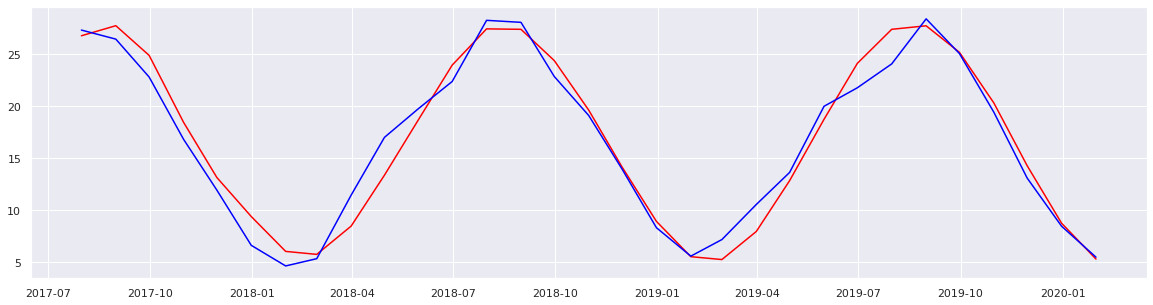

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(20,5))

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red',label="pred")

#2つ目のデータをplotメソッドでプロット
plt.plot(test, color = 'blue',label="acutual")
plt.show()

### rmse算出

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test,pred)))

RMSE 1.6246677986471116
